In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

#### Upload the dataset

In [13]:
reduced_books_users_ratings_locations = pd.read_csv("https://raw.githubusercontent.com/GoldbergData/Machine-Learning-Book-Ratings/master/data/clean/reduced_books_users_ratings_locations.csv")
reduced_books_users_ratings_locations.head(2)

,user_id,isbn,book_rating,book_title,book_author,year_of_publication,publisher,unique_isbn,age,city,state,country
0,16877,038550120X,9,A Painted House,JOHN GRISHAM,2001,Doubleday,038550120X,37.0,houston,arkansas,usa
1,16877,034539657X,7,Dark Rivers of the Heart,Dean R. Koontz,1995,Ballantine Books,034539657X,37.0,houston,arkansas,usa


#### Calculate total ratings

In [14]:
book_total_rating = (reduced_books_users_ratings_locations.
     groupby(by = ['book_title'])['book_rating'].
     count().
     reset_index().
     rename(columns = {'book_rating': 'total_rating_count'})
     [['book_title', 'total_rating_count']]
    )
book_total_rating.head()

,book_title,total_rating_count
0,'Salem's Lot,19
1,10 Lb. Penalty,15
2,100 Selected Poems by E. E. Cummings,6
3,101 Dalmatians,9
4,11-Sep,13


In [15]:
book_rating_count_user = reduced_books_users_ratings_locations.merge(book_total_rating, left_on = 'book_title', right_on = 'book_title', how = 'left')
book_rating_count_user.head()

,user_id,isbn,book_rating,book_title,book_author,year_of_publication,publisher,unique_isbn,age,city,state,country,total_rating_count
0,16877,038550120X,9,A Painted House,JOHN GRISHAM,2001,Doubleday,038550120X,37.0,houston,arkansas,usa,237
1,16877,034539657X,7,Dark Rivers of the Heart,Dean R. Koontz,1995,Ballantine Books,034539657X,37.0,houston,arkansas,usa,32
2,16877,743211383,3,Dreamcatcher,Stephen King,2001,Scribner,61083259,37.0,houston,arkansas,usa,150
3,16877,786868716,10,The Five People You Meet in Heaven,Mitch Albom,2003,Hyperion,786868716,37.0,houston,arkansas,usa,168
4,16877,440159016,10,Motherhood: The Second Oldest Profession,Erma Bombeck,1987,Dell,70064547,37.0,houston,arkansas,usa,6


In [16]:
book_rating_count_user = book_rating_count_user.drop(['isbn','book_author','year_of_publication','publisher','age','city','state','country'], axis = 1)
book_rating_count_user.head()

,user_id,book_rating,book_title,unique_isbn,total_rating_count
0,16877,9,A Painted House,038550120X,237
1,16877,7,Dark Rivers of the Heart,034539657X,32
2,16877,3,Dreamcatcher,61083259,150
3,16877,10,The Five People You Meet in Heaven,786868716,168
4,16877,10,Motherhood: The Second Oldest Profession,70064547,6


In [17]:
print(book_total_rating['total_rating_count'].quantile(np.arange(.9, 1, .01)))

0.90     41.00
0.91     44.00
0.92     48.00
0.93     52.00
0.94     57.00
0.95     62.00
0.96     71.00
0.97     83.00
0.98     99.42
0.99    135.21
Name: total_rating_count, dtype: float64


In [18]:
popularity_threshold = 135 # to ensure statistical significance ==> top 5 % 
rating_by_popularity = book_rating_count_user.query('total_rating_count >= @popularity_threshold')
print(rating_by_popularity.shape)
rating_by_popularity.head()

(10976, 5)


,user_id,book_rating,book_title,unique_isbn,total_rating_count
0,16877,9,A Painted House,038550120X,237
2,16877,3,Dreamcatcher,61083259,150
3,16877,10,The Five People You Meet in Heaven,786868716,168
6,20806,6,A Painted House,038550120X,237
10,21340,9,A Painted House,038550120X,237


In [19]:
# Remove book title for now. Will match later
rating_by_popularity = rating_by_popularity.drop(['book_title'], axis = 1)
rating_by_popularity.head()

,user_id,book_rating,unique_isbn,total_rating_count
0,16877,9,038550120X,237
2,16877,3,61083259,150
3,16877,10,786868716,168
6,20806,6,038550120X,237
10,21340,9,038550120X,237


In [20]:
# # Encode unique isbn column 
lb_make = LabelEncoder()
rating_by_popularity['unique_isbn'] = lb_make.fit_transform(rating_by_popularity['unique_isbn'])

rating_by_popularity.head() 

,user_id,book_rating,unique_isbn,total_rating_count
0,16877,9,0,237
2,16877,3,48,150
3,16877,10,55,168
6,20806,6,0,237
10,21340,9,0,237


In [21]:
X = rating_by_popularity.drop(['book_rating'], axis = 1)
y = rating_by_popularity['book_rating']

In [22]:
# Split into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=55)

In [23]:
print(X_train.shape)
print(y_train.shape)

(7683, 3)
(7683,)


#### Run kNN algorithm to predict total ratings

In [24]:
knn_clf = KNeighborsClassifier()
k_range = list(range(1, 100))
print(k_range)

param_grid = dict(n_neighbors=k_range)
print(param_grid)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]}


#### Use Gridsearch to find optimal k

In [195]:
grid = GridSearchCV(knn_clf, param_grid, cv=10, scoring='accuracy')
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [25]:
# Fit the best model
knn_best = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')
knn_best.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

#### Make predictions of total ratings

In [26]:
knn_best_preds = knn_best.predict(X_test)
print(accuracy_score(y_test, knn_best_preds))

0.2456726389310659


#### Calculate MSE and RMSE

In [27]:
meanSquaredError=mean_squared_error(y_test, knn_best_preds)
print("MSE:", meanSquaredError)
rootMeanSquaredError = sqrt(meanSquaredError)
print("RMSE:", rootMeanSquaredError)

MSE: 6.149711509262071
RMSE: 2.479861187498621


#### Check for overfitting

In [28]:
knn_best_preds_train = knn_best.predict(X_train)
print(accuracy_score(y_train, knn_best_preds_train))

0.47234153325523887


In [29]:
meanSquaredError=mean_squared_error(y_train, knn_best_preds_train)
print("MSE:", meanSquaredError)
rootMeanSquaredError = sqrt(meanSquaredError)
print("RMSE:", rootMeanSquaredError)

MSE: 4.4079135754262655
RMSE: 2.0995031734737304


#### Look at top 5 predictions of total ratings

In [202]:
knn_best_preds[:5]

array([164, 135, 140, 224, 135])

#### Use CV to find optimal k

In [203]:
# creating odd list of K for KNN
myList = list(range(1,100))

# subsetting just the odd ones
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn_best2 = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=k, p=2,
           weights='uniform')
    scores = cross_val_score(knn_best2, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

The optimal number of neighbors is 67


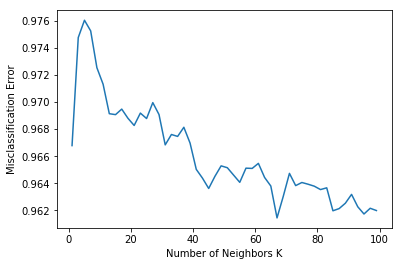

In [205]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

#### Look at predictions distribution

In [215]:
knn_best_preds.quantile([.9, 1, .01]) # matches our popularity index

,0
0.90,191.0
1.00,431.0
0.01,135.0


In [214]:
knn_best_preds = pd.DataFrame(knn_best_preds)

In [ ]:
popularity_threshold = 135 # to ensure statistical significance ==> top 5 % 
rating_by_popularity = book_rating_count_user.query('total_rating_count >= @popularity_threshold')
print(rating_by_popularity.shape)
rating_by_popularity.head()

In [220]:
predictions_threshold = 135 # to ensure statistical significance ==> top 5 % 
predictions = book_rating_count_user.query('total_rating_count >= @predictions_threshold')
predictions.shape # over 10,976 recommendations we can run Nearest Neighbors on

(10976, 5)